# Automated Species Identification in a Microcosm experiment

## Introduction

Working on ecosystem stability, my PhD led me to follow the dynamics of microcosms -- artificial, simplified ecosystem made of vials and tubes and inhabited by different species of unicellular organisms.
This entailed identifying and counting hundreds of thousands of individuals in more than 250 vials at regular intervals over the course of a month.

Thankfully, automation of the identification process allowed me to realize this otherwise daunting task.
I took video samples regularly which I analyzed with the Bemovi R-package [cite Emanuel] that tracks individuals (moving particles) and extracts information on them such as their size, shape and trajectory properties.
Bemovie outputs a dataframe where each row is a single individual and columns describe their properties which is well suited for classification methods.
I could thus train a machine learning algorithm on monospecific cultures (videos with only one species so we are sure about the species identity) and then use it to predict species identity in plurispecific cultures.

At the time, I automated species recognition in R by slapping a Random Forest algorithm with default parameters on my data, checking visually that this worked most of the time and called it a day.

Now that I know better, I would like to come back to this data and do better by benchmarking different ML algorithm and estimating accuracy by splitting the data into a training set and a testing set.
I will also further assess the robustness of each method by checking its accuracy on training datasets obtained at later dates, and by estimating accuracy on a dataset with added noise.
In this post, I will guide you through the automation process starting from the output of Bemovi (a dataframe describing the properties of each tracked particle) using python and Sklearn.


## Data importation and preparation

Let us first import a few libraries and import our training data set:

In [1]:
## libraries importation

# data manipulation and maths
import pandas as pd
import numpy as np

# plot libraries
import matplotlib.pyplot as plt
import seaborn as sns

# importing data and looking at the first few rows
## loading data
data = pd.read_csv('datasets/morph_data_t0.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15885 entries, 0 to 15884
Data columns (total 35 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   file             15885 non-null  object 
 1   mean_grey        15885 non-null  float64
 2   sd_grey          15885 non-null  float64
 3   mean_area        15885 non-null  float64
 4   sd_area          15885 non-null  float64
 5   mean_perimeter   15885 non-null  float64
 6   sd_perimeter     15885 non-null  float64
 7   mean_major       15885 non-null  float64
 8   sd_major         15885 non-null  float64
 9   mean_minor       15885 non-null  float64
 10  sd_minor         15885 non-null  float64
 11  mean_ar          15885 non-null  float64
 12  sd_ar            15885 non-null  float64
 13  mean_turning     15885 non-null  float64
 14  sd_turning       15885 non-null  float64
 15  duration         15885 non-null  float64
 16  N_frames         15885 non-null  int64  
 17  max_net     

This dataframe was obtained by using bemovi package, which tracks individuals from video files.
It outputs a dataframe where each line describes the properties of a tracked particle (here, a unicellular organism) such as its area, size or color.
Our target variable is contained in the "Community" column (but we'll see later that we also need to transform this variable).

Some of the columns are meta-data that will not be usefull for the identification:
- 'file': the name of the video file from whitch the individual was tracked.
- 'id': a unique number identifying the individual.
- 'date', 'time: the date and time of video recording.
- 'magnification': microscope setting. Not informative since we use the same magnification for the whole experiment.
- 'tube_id': a unique number identifying the falcon tube from which the sample was taken.
- 'measure_point': a categorical variable describing the order of measurements.

Let's get rid of these columns:

In [2]:
# dropping useless columns for id:
data.drop(['file',
           'id',
           'date',
           'time',
           'magnification',
           'tube_id',
           'measure_point'],
          axis = 1, inplace = True)

A first thing we can do is take a look at how the variables relate to each other and to the target variable.
Because we have a lot of variables (28 columns) and observations (15885 rows), we'll only take a look at a few variables on a subset of the data (1000 rows).
Using a pairplot, let's take a look at the following variables of interest, grouped by species id:
- 'mean_grey': average grey level of an individual.
- 'mean_area': average area of an individual.
- 'mean_ar': mean aspect ratio (length relative to width), describes the individuals shape.
- 'duration': time during which an individual was tracked. Small and fast individuals tend to get 'lost' by the tracking algorithm and have a shorter duration.
- 'gross_speed': speed of the individual

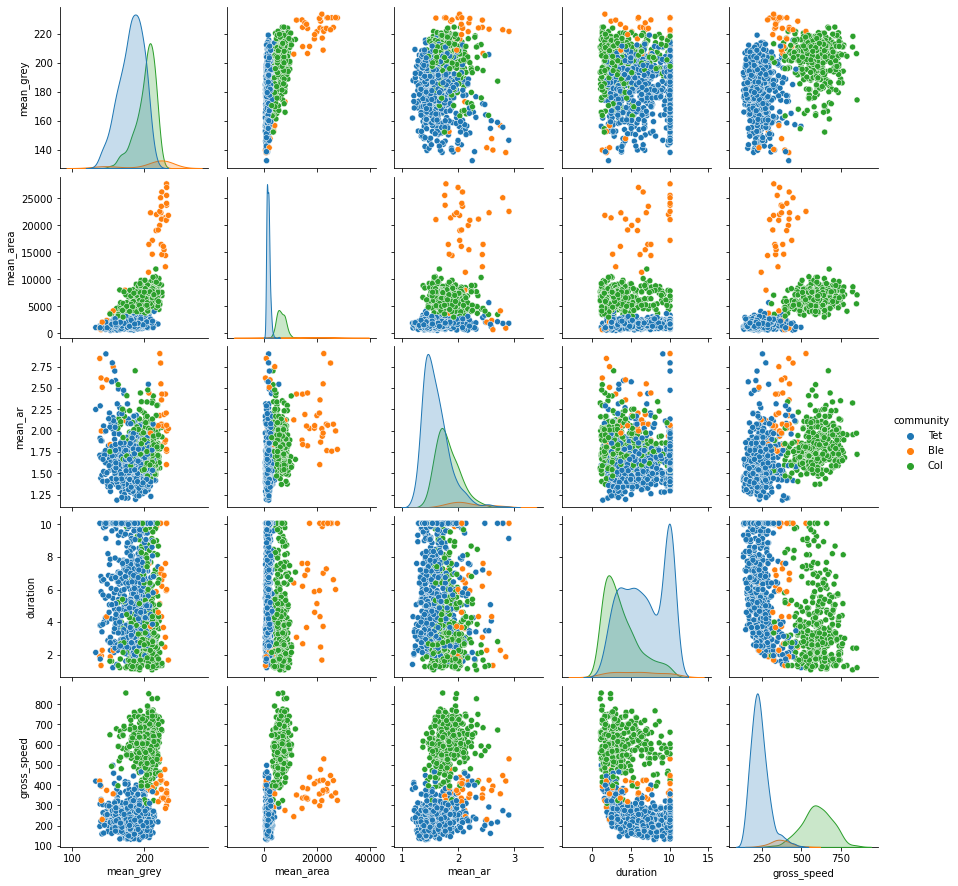

In [3]:
# sampling part of the data and looking at pairplot for a few values that we think could be of interest
data_sample =  data[['mean_grey', # particle color
                     'mean_area', # particle area
                     'mean_ar', # particle elongation (Aspect Ratio)
                     'duration',
                     'gross_speed',
       'community']].sample(1000)
sns.pairplot(data_sample, hue = 'community')

We can already see that the species are well separated by some variables such as their size ('mean_area') and speed ('gross_speed').

It is also worth noting that the variables are on very different scales (e.g., mean_area: 0-35000 vs. mean_grey: 100-250) so we'll need to rescale them. We also note quite a lot of outliers, so we'll want to make sure that we use a scaler that is not sensitive to outliers.

Lastly, we see that Blepharisma sp. are a bit underrepresented so it's hard to make them out. Lets look at them separately:

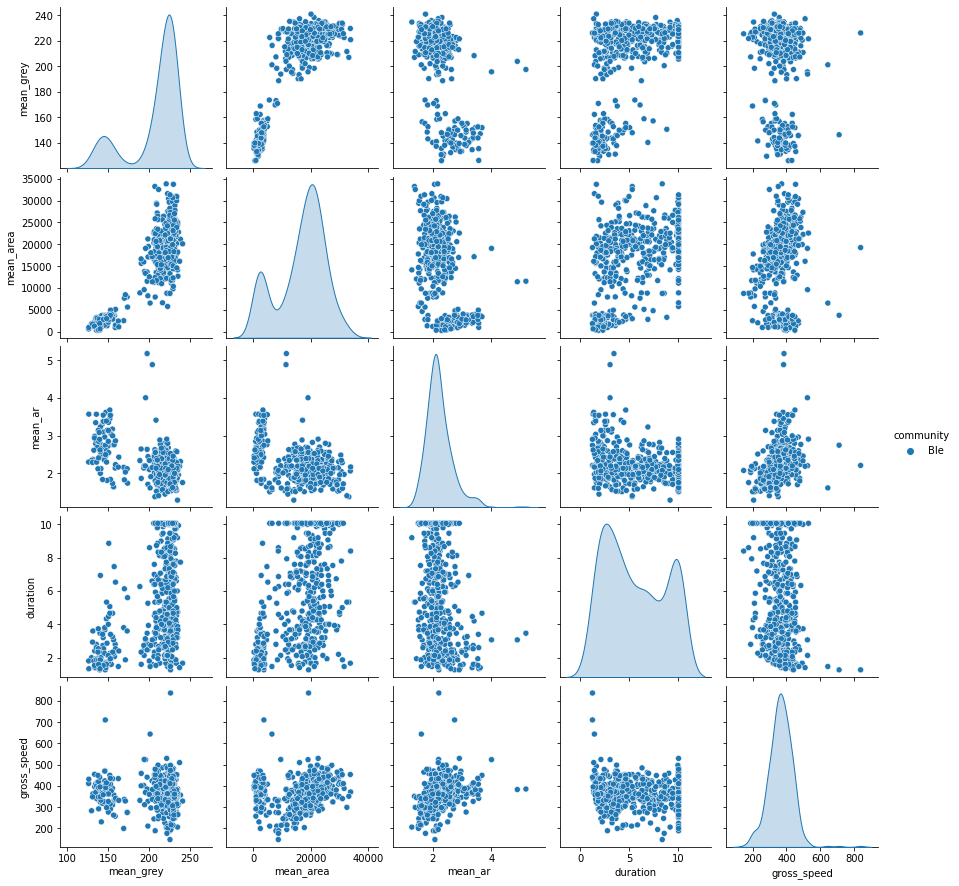

In [4]:
# sampling part of the data and looking at pairplot for a few values that we think could be of interest
data_sample_ble =  data[data.community == 'Ble'][['mean_grey', 'mean_area', 'mean_ar',
       'duration', 'gross_speed',
       'community']]

sns.pairplot(data = data_sample_ble, hue = 'community')

As you can see, the color and size of Blepharisma are bimodal. Taking a look at the video, you could see that Blepharisma sp. are so big that they cast a reflection on the bottom of the microscope slide which gets picked up by the tracking algorithm. Originally, I arbitrarily took all Blepharisma sp. with a mean_grey smaller than 180 and gave them the new label 'Ble_shadow'. Here, we'll try to relabel them using a clustering algorithm to be more robust (i.e., if next week we change the microscope's light bulb, the grey threshold might not be 180 for future videos).
We do that by running a clustering algorithm on the grey level and area of particles labelled 'Ble':

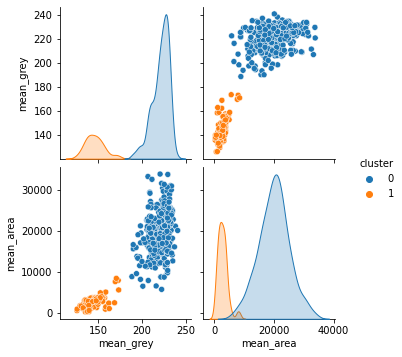

In [5]:
# importing a scaler and clustering algorithm
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering

# extracting Blepharisma's area and color
X_ble = data[data.community == 'Ble'][['mean_grey', 'mean_area']]

# scaling it
X_ble_scaled = MinMaxScaler().fit_transform(X_ble)

# running an agglomerative clustering on it and storing the cluster id in data_sample_ble
model_ble = AgglomerativeClustering(n_clusters = 2, linkage = 'complete')
data_sample_ble['cluster'] = model_ble.fit_predict(X_ble_scaled)

# Visually checking the new clusters:
sns.pairplot(data_sample_ble[['mean_grey', 'mean_area', 'cluster']], hue = 'cluster')

This seems to work quite well ! All that's left to do is to associate cluster 1 (the smallest individuals) to the label 'Ble_shadow' and then port that to the main data into a new column that we'll call 'species':

In [6]:
# associating each cluster to the right label
data_sample_ble['species'] = data_sample_ble.cluster.apply(lambda x: x*'Ble_shadow' + (x-1)**2 * 'Ble')

# Putting that to the full data frame
data['species'] = data.community
data.loc[data.community == 'Ble', 'species'] = data_sample_ble['species']

Finally, we can drop the column 'community', and split our data between training and testing set and we'll be ready to fit !

In [7]:
# separating features from labels
y = data.species.values
X = data.drop(['community', 'species'], axis = 1).values

# train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

## Model fitting

First let's import some libraries:

In [8]:
## Utility functions
from sklearn.pipeline import Pipeline

#æ parmeter tuning and model validation
from sklearn.model_selection import train_test_split, GridSearchCV

## feature scaling
from sklearn.preprocessing import RobustScaler

## models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import RidgeClassifier

# to time the fit of each function
import time
from datetime import timedelta



Now we declare a list of models and parameter grids to explore for each:

In [9]:
names = ['knn', 'random_forest',
         'neuralnet', 'SVC', 'ridge']
classifiers = [KNeighborsClassifier(), RandomForestClassifier(),
               MLPClassifier(max_iter = 500), LinearSVC(), RidgeClassifier()]
params = [{'knn__n_neighbors': range(1, 10)},
          {'random_forest__n_estimators': [50, 100, 200]},
          {'neuralnet__hidden_layer_sizes': [(80), (40, 10), (30, 10, 5)]},
          {'SVC__C': [0.5, 1.0, 2.0]},
          {'ridge__alpha': [0.5, 1.0, 2.0, 5.0, 10.0]}
]

Lastly, we fit each model to the training data and extract the accuracy score on the test data:

In [10]:
model_cv = []
scores_list = []
times = []
for k in range(len(names)):
    model_cv.append(GridSearchCV(Pipeline([('scaler', RobustScaler()), (names[k], classifiers[k])]),
                               params[k], cv = 5))
    start_time = time.monotonic()
    model_cv[k].fit(X_train, y_train)
    end_time = time.monotonic()
    scores_list.append(model_cv[k].score(X_test, y_test))
    times.append(timedelta(seconds=end_time - start_time))

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warning

In [11]:
scores = pd.DataFrame({'model': names, 'test_score' : scores_list, 'train_score' : [m.best_score_ for m in model_cv], 'time' : [t.seconds for t in times]})
scores.sort_values('test_score', inplace = True, ascending = False)

Comparing the accuracy of different models, testing on the left and training on the right:

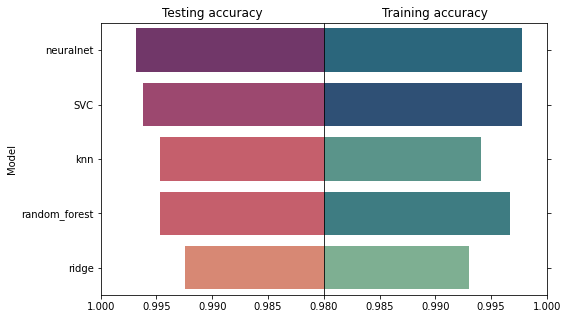

In [12]:
fig, ax = plt.subplots(figsize=(8, 5), ncols=2, sharey=True)
#fig.tight_layout()

sns.barplot(ax = ax[0], x="test_score", y="model", data=scores, hue = 'test_score', dodge=False, palette = 'flare')
ax[0].legend_.remove()
ax[0].set_xlim(0.98, 1)
ax[0].set_title('Testing accuracy')
ax[0].invert_xaxis()
ax[0].set(ylabel = 'Model', xlabel = '')

sns.barplot(ax=ax[1], x="train_score", y="model", data=scores, hue = 'train_score', dodge=False, palette = 'crest')
ax[1].legend_.remove()
ax[1].set_xlim(0.98, 1)
ax[1].set_title('Training accuracy')
ax[1].set(ylabel = '', xlabel = '')
ax[1].yaxis.tick_right()
ax[1].set_xticks(ax[1].get_xticks()[1:])

plt.subplots_adjust(wspace=0)

Checking the runtime of each model (right):

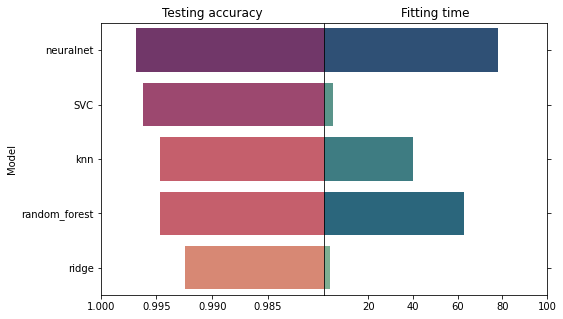

In [13]:
fig, ax = plt.subplots(figsize=(8, 5), ncols=2, sharey=True)
#fig.tight_layout()

sns.barplot(ax = ax[0], x="test_score", y="model", data=scores, hue = 'test_score', dodge=False, palette = 'flare')
ax[0].legend_.remove()
ax[0].set_xlim(0.98, 1)
ax[0].set_title('Testing accuracy')
ax[0].invert_xaxis()
ax[0].set(ylabel = 'Model', xlabel = '')
ax[0].set_xticks(ax[0].get_xticks()[1:])

sns.barplot(ax=ax[1], x="time", y="model", data=scores, hue = 'time', dodge=False, palette = 'crest')
ax[1].legend_.remove()
ax[1].set_title('Fitting time')
ax[1].set(ylabel = '', xlabel = '')
ax[1].yaxis.tick_right()
ax[1].set_xticks(ax[1].get_xticks()[1:])

plt.subplots_adjust(wspace=0)

All models are quite good with more than 99% accuracy on the test set. SVC is very efficient given its fast training time but I'm a bit worried by the convergence warnings. Also consider that models with few parameters (SVC, knn and ridge) are probably close to their best performance already but neural net and random forest could probably be improved through hyperparameter fine tuning.

If 1% error is not an issue for you, I would recommend using knn or ridge as they are already very accurate but are also super easy and fast to tune.
If having a very high accuracy matters, I would recommend using a neuralnet and taking some more time to fine tune the parameters.

However, I'd like to make 2 final tests to check that our models are efficient on tricky data to make sure that they generalize well and get an idea of the worst performance we can expect.

## Model assessment on tricky data

To check the robustness of the different models by using tricky test data, namely:
- on data taken another day, as unicellular organisms are fairly plastic and their traits can vary over time.
- on noisy data, by applying some white noise to the individual's traits.


### Data importation automation
In order to test the models on more data, I need to declare a function that automates data processing (dropping useless columns, classifying Ble/Ble_Shadow).

In [14]:
def clean_data(data):
    # dropping useless columns for id:
    data.drop(['file', # name of the video file where the particle comes from
           'id',   # id of the particle
           'date', # date of the video
           'time', # hour of the video
           'magnification', # microscope setting
           'tube_id', # id of the tube the sample comes from
           'measure_point'], # a categorical variable that describe which measurement it was in the experiment.
          axis = 1, inplace = True)
    ## identifying Ble_shadows
    # extracting Blepharisma's area and color
    X_ble = data[data.community == 'Ble'][['mean_grey', 'mean_area']]

    # scaling it
    X_ble_scaled = MinMaxScaler().fit_transform(X_ble)

    # running an agglomerative clustering on it and storing the cluster id in data_sample_ble
    model_ble = AgglomerativeClustering(n_clusters = 2, linkage = 'complete')
    cluster = pd.Series(model_ble.fit_predict(X_ble_scaled))
    
    # associating each cluster to the right label
    species = cluster.apply(lambda x: x*'Ble_shadow' + (x-1)**2 * 'Ble')

    # Putting that to the full data frame
    data['species'] = data.community
    data.loc[data.community == 'Ble', 'species'] = species
    
    return None

### fitting the models to all data points

The data I used to fit the model was taken on the first day of the experiment ('datasets/morph_data_t0.csv'), but we also have 11 more data sets (t1 to t11) taken in the following days.
I will now test the models on this data to assess their robustness:

In [15]:
# Creating a dataframe that will store the accuracy of each model on each data set
temp_df = pd.DataFrame({'model':names})

## looping over all times
for time in range(1, 12):
    file = 'datasets/morph_data_t' + str(time) + '.csv'
    temp_data = pd.read_csv(file)
    clean_data(temp_data)
    # separating features from labels
    y_temp = temp_data.species.values
    X_temp = temp_data.drop(['community', 'species'], axis = 1).values
    
    
    ## Creating a list of scores for this time step
    
    t_score = []
    
    ## fitting each model at given time
    for model_id in range(len(names)):
        t_score.append(model_cv[model_id].score(X_temp, y_temp))

    temp_df['t_' + str(time)] = t_score


In [16]:
temp_df

,model,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,t_10,t_11
0,knn,0.987349,0.984904,0.985214,0.946599,0.957288,0.987789,0.976901,0.965896,0.974500,0.936820,0.970832
1,random_forest,0.990536,0.991766,0.991418,0.955245,0.962504,0.989417,0.986051,0.985130,0.984590,0.948536,0.978935
2,neuralnet,0.992854,0.993666,0.994520,0.955372,0.963913,0.991859,0.986351,0.974947,0.986975,0.950209,0.981568
3,SVC,0.991695,0.989760,0.993072,0.952956,0.964336,0.991534,0.980501,0.965896,0.984223,0.948117,0.978935
4,ridge,0.988218,0.984904,0.988109,0.953592,0.959825,0.981276,0.973751,0.977534,0.984407,0.950209,0.975289


We can now aggregate this dataframe to get the average accuracy over all data points:

In [17]:
temp_df_long = temp_df.melt(id_vars='model', value_vars=['t_' + str(k) for k in range(1,12)], var_name = 'Measurement', value_name = 'Accuracy')
mean_sd_scores = temp_df_long.groupby('model').agg(Accuracy_mean = ('Accuracy', 'mean'), Accuracy_std = ('Accuracy', 'std'))
mean_sd_scores.reset_index(inplace = True)

In [18]:
scores = scores.merge(mean_sd_scores, on = 'model')

In [19]:
scores

,model,test_score,train_score,time,Accuracy_mean,Accuracy_std
0,neuralnet,0.996852,0.997718,78,0.979294,0.016024
1,SVC,0.996223,0.997718,4,0.976457,0.016153
2,knn,0.994649,0.994098,40,0.970372,0.017219
3,random_forest,0.994649,0.996695,63,0.978557,0.015619
4,ridge,0.992446,0.992996,3,0.974283,0.013704


Let us plot the average accuracy of the different models:

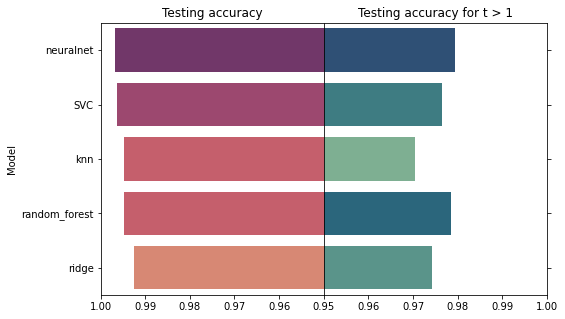

In [20]:
fig, ax = plt.subplots(figsize=(8, 5), ncols=2, sharey=True)
#fig.tight_layout()

sns.barplot(ax = ax[0], x="test_score", y="model", data=scores, hue = 'test_score', dodge=False, palette = 'flare')
ax[0].legend_.remove()
ax[0].set_xlim(0.95, 1)
ax[0].set_title('Testing accuracy')
ax[0].invert_xaxis()
ax[0].set(ylabel = 'Model', xlabel = '')

sns.barplot(ax=ax[1], x="Accuracy_mean", y="model", data=scores, hue = 'Accuracy_mean', dodge=False, palette = 'crest')
ax[1].legend_.remove()
ax[1].set_xlim(0.95, 1)
ax[1].set_title('Testing accuracy for t > 1')
ax[1].set(ylabel = '', xlabel = '')
ax[1].yaxis.tick_right()
ax[1].set_xticks(ax[1].get_xticks()[1:])

plt.subplots_adjust(wspace=0)

### fitting the models to noisy data

Lastly, I want to artificially create tricky data by applying some white noise to the data.
I first define a function that returns noisy data from clean data, and then test the models over different noise amplitudes (sd).

In [21]:
# defining a function that adds noise to data
def add_noise(X, sd):
    noise_array = np.random.normal(1, sd, X.shape)
    return(X*noise_array)

In [22]:
# defining the range of noise amplitude we want to explore
sd_space = np.linspace(0, 0.3, 6)

# creating some lists to store the model names, noise amplitude, and accuracy
temp_models = []
sd_list = []
accuracy = []

# looping over several replicates and noise amplitudes
for replicate in range(20):
    for sd in sd_space:

        X_train_noisy = add_noise(X_train, sd)

        X_test_noisy = add_noise(X_test, sd)

        ## fitting each model at given time
        for model_id in range(len(names)):
            model = model_cv[model_id].best_estimator_
            model.fit(X_train_noisy, y_train)
            accuracy.append(model.score(X_test_noisy, y_test))
            temp_models.append(names[model_id])
            sd_list.append(sd)


noise_df_long = pd.DataFrame({'model': temp_models, 'Sd': sd_list, 'Accuracy': accuracy})


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warning

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warning

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warning

In [23]:
noise_df_long.head()

,model,Sd,Accuracy
0,knn,0.0,0.994649
1,random_forest,0.0,0.995279
2,neuralnet,0.0,0.996223
3,SVC,0.0,0.996223
4,ridge,0.0,0.992446


Finally, we can plot the accuracy of the different models against the noise amplitude:

[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Noise amplitude')]

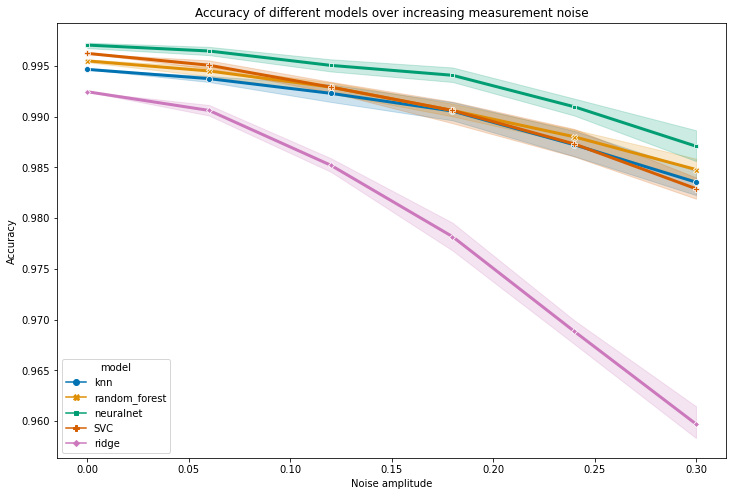

In [24]:
fig, ax = plt.subplots(figsize=(12, 8), sharey=True)
sns.lineplot(ax = ax, data = noise_df_long,
             x = 'Sd', y = 'Accuracy',
             ci = 100,
             hue = 'model', style = "model",
             palette = 'colorblind', linewidth = 3,
    markers=True, dashes = False)
ax.set_title('Accuracy of different models over increasing measurement noise')
ax.set(ylabel = 'Accuracy', xlabel = 'Noise amplitude')

## Conclusion

All models are quite robust, with the accuracy never falling below 96%. The neural net model seems to be the more robust, reaching a higher accuracy than other models on tricky data despite the rough tuning of its hyper-parameters. As such, it would probably be my go-to model for future similar species identification tasks.